In [3]:
!pip install --upgrade opencv-contrib-python

In [1]:
!pip install segmentation-models-pytorch

  Using cached segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata (30 kB)
  Using cached torchvision-0.17.2-cp311-cp311-win_amd64.whl.metadata (6.6 kB)
  Using cached pretrainedmodels-0.7.4-py3-none-any.whl
  Using cached efficientnet_pytorch-0.7.1-py3-none-any.whl
  Using cached timm-0.9.2-py3-none-any.whl.metadata (68 kB)
  Using cached huggingface_hub-0.22.2-py3-none-any.whl.metadata (12 kB)
Using cached segmentation_models_pytorch-0.3.3-py3-none-any.whl (106 kB)
Using cached timm-0.9.2-py3-none-any.whl (2.2 MB)
Using cached torchvision-0.17.2-cp311-cp311-win_amd64.whl (1.2 MB)
Using cached huggingface_hub-0.22.2-py3-none-any.whl (388 kB)


In [2]:
!pip install albumentations

   ---------------------------------------- 0.0/137.0 kB ? eta -:--:--
   ---------------------------------------- 137.0/137.0 kB 4.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
    --------------------------------------- 0.8/38.5 MB 23.4 MB/s eta 0:00:02
   - -------------------------------------- 1.6/38.5 MB 20.7 MB/s eta 0:00:02
   --- ------------------------------------ 3.0/38.5 MB 23.6 MB/s eta 0:00:02
   ----- ---------------------------------- 5.3/38.5 MB 31.0 MB/s eta 0:00:02
   ------- -------------------------------- 7.6/38.5 MB 34.5 MB/s eta 0:00:01
   ---------- ----------------------------- 9.8/38.5 MB 36.8 MB/s eta 0:00:01
   ------------- -------------------------- 12.8/38.5 MB 43.7 MB/s eta 0:00:01
   -------------- ------------------------- 14.4/38.5 MB 43.7 MB/s eta 0:00:01
   ----------------- ---------------------- 16.4/38.5 MB 43.7 MB/s eta 0:00:01
   ------------------ --------------------- 18.0/38.5 MB 40.9 MB/s eta 0:0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A
from albumentations import HorizontalFlip, VerticalFlip, Rotate


height,width = (512, 512)

torch.cuda.is_available()

False

In [3]:
X = sorted(glob.glob('Water Bodies Dataset/Images/*'))
y = sorted(glob.glob('Water Bodies Dataset/Masks/*'))

In [4]:
len(y)

2841

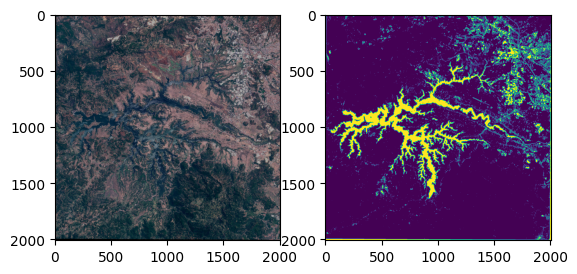

In [5]:
img = Image.open(X[0])
mask = Image.open(y[0]).convert('L')
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(mask)

In [6]:
X_=X[0]
y_=y[0]

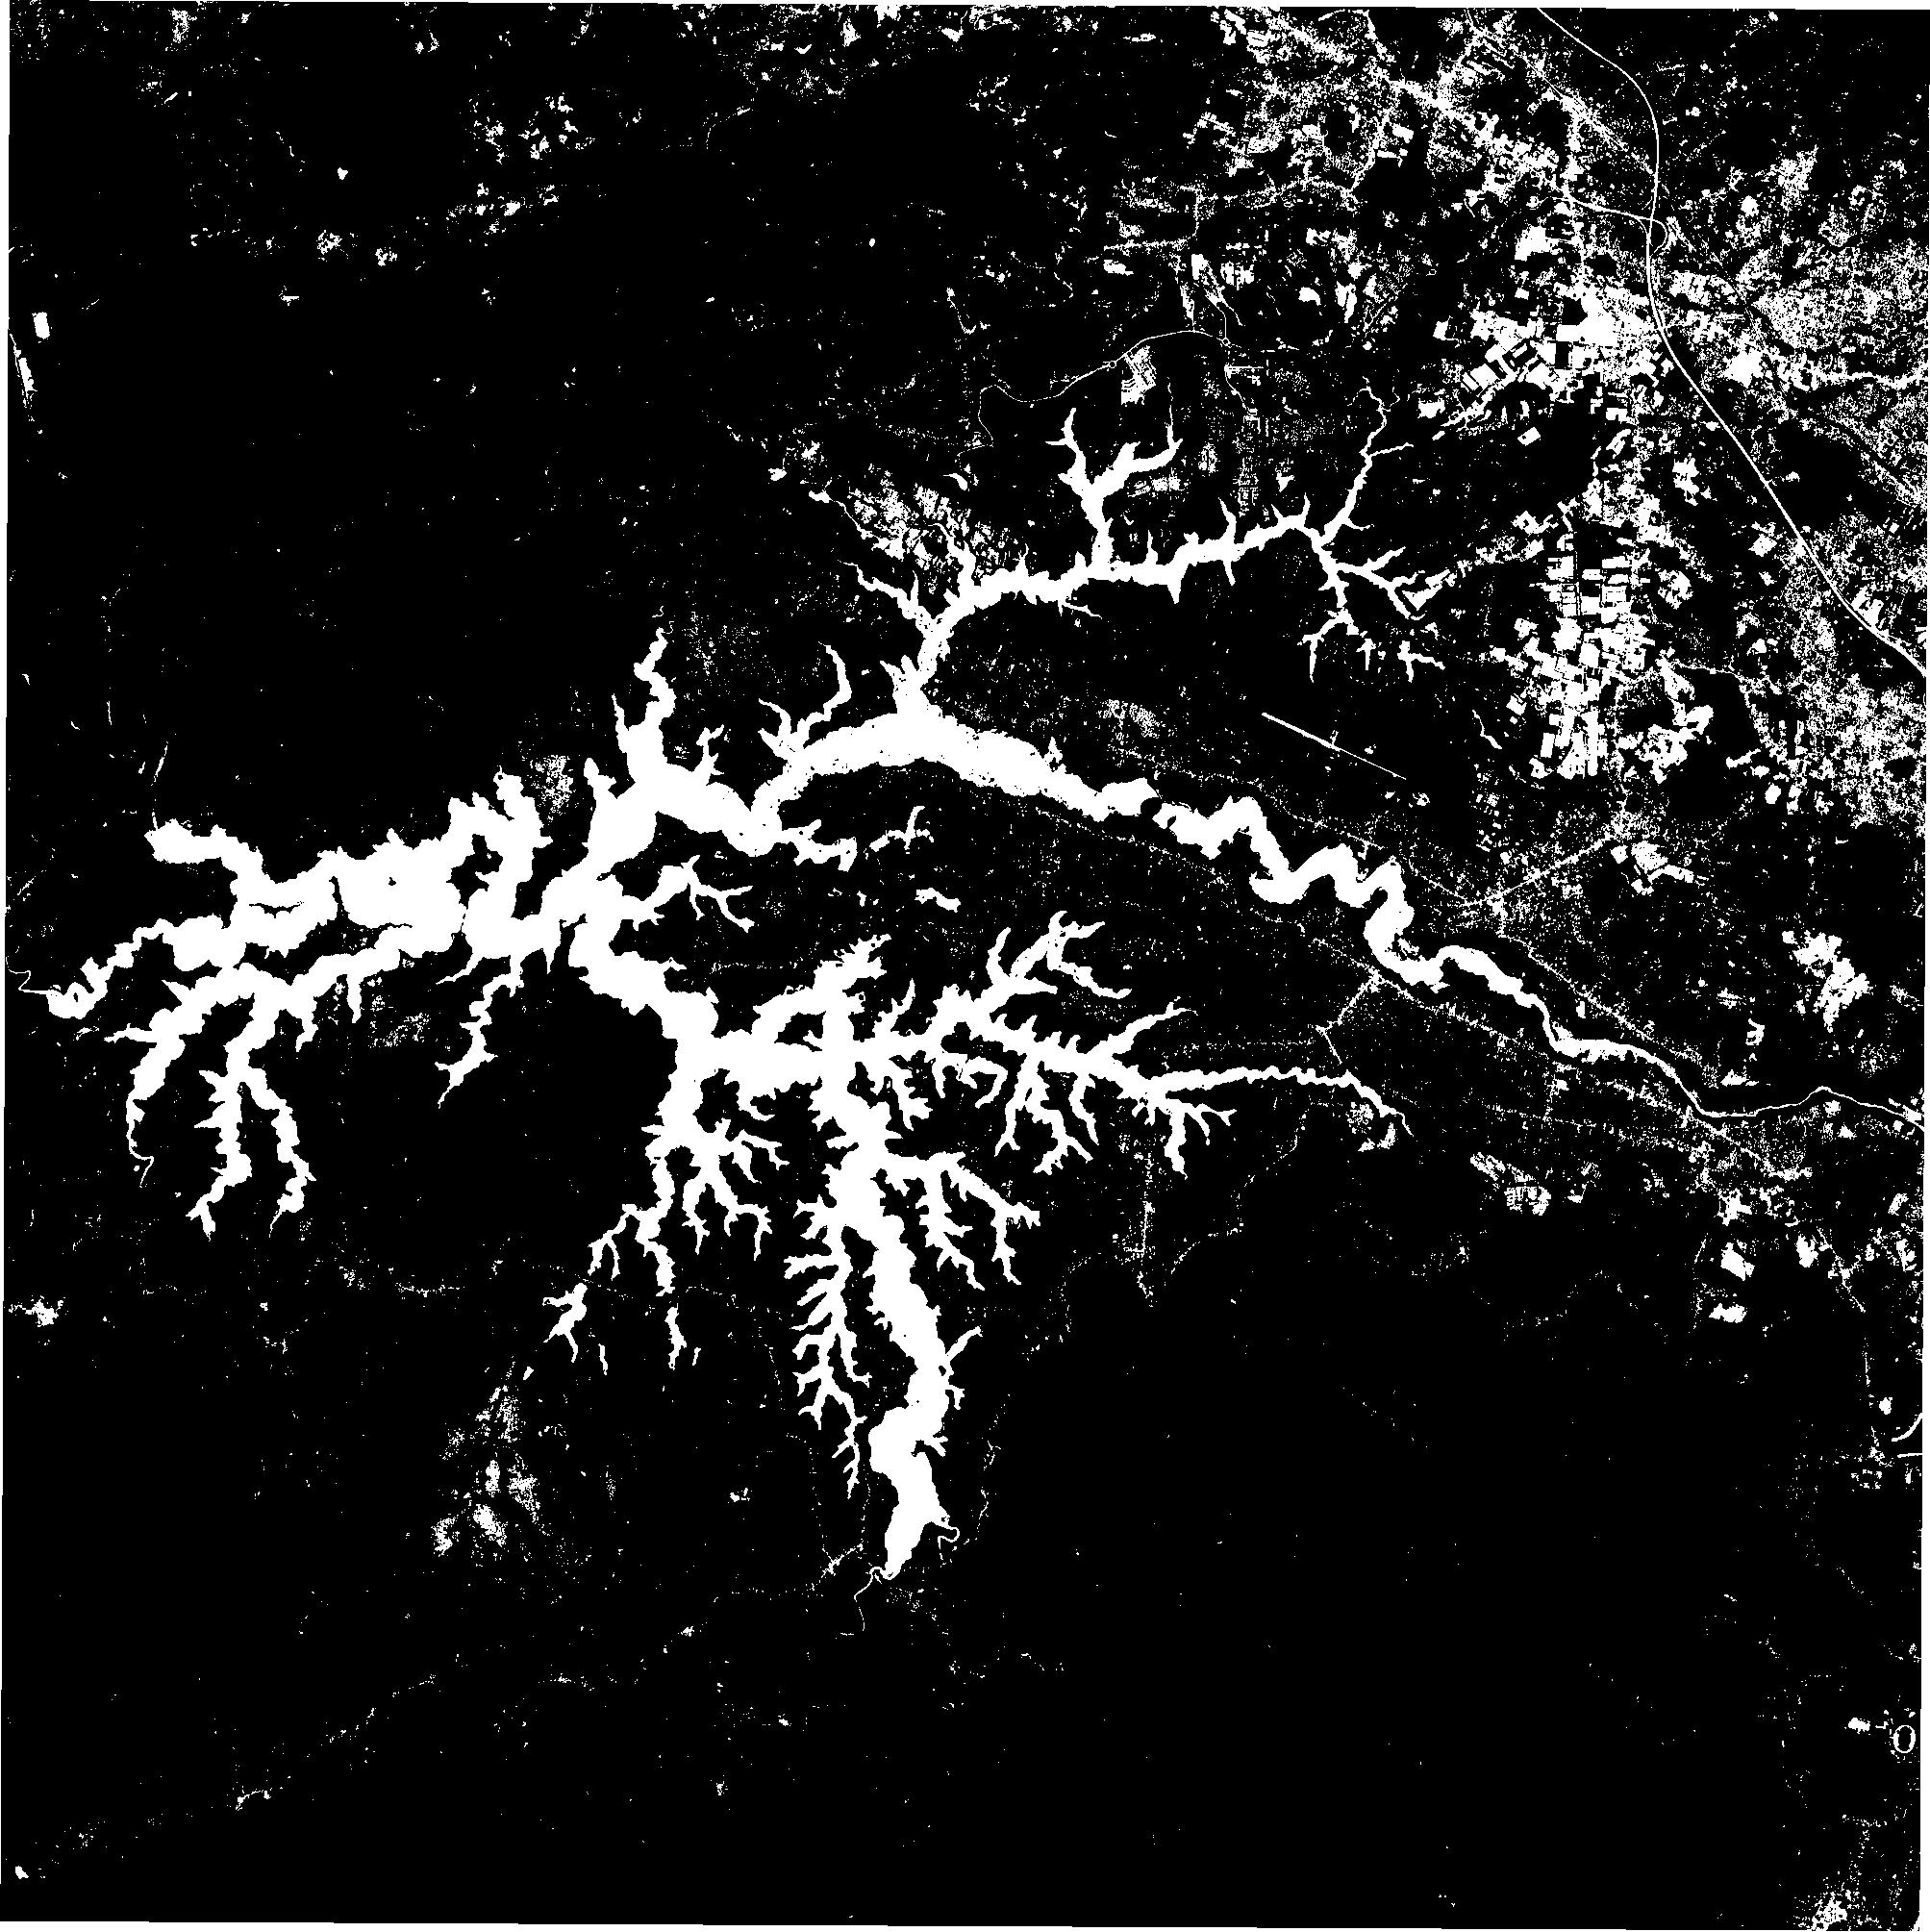

In [7]:
img = Image.open(X_)
mask = Image.open(y_).convert('L')

mask

In [8]:
img, mask = np.array(img), np.array(mask)
transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
        ])
transformed = transform(image=img, mask=mask)
img = transformed['image']
mask = transformed['mask']

In [9]:
mask.shape

(512, 512)

In [10]:
img = np.transpose(img, (2, 0, 1))
img = img/255.0
img = torch.tensor(img)

mask = np.expand_dims(mask, axis=0)
mask = mask/255.0
mask = torch.tensor(mask)

In [11]:
img.shape, mask.shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

In [18]:
class Load_Data(Dataset):
    def __init__(self, image_list, mask_list):
        super().__init__()

        self.images_list = image_list
        self.mask_list = mask_list
        self.len = len(image_list)
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
            #A.RandomBrightnessContrast(p=0.5),
            #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])
        
    def __getitem__(self, idx):
        img = Image.open(self.images_list[idx])
        mask = Image.open(self.mask_list[idx]).convert('L')
        
        img, mask = np.array(img), np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask

    def __len__(self):
        return self.len

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [20]:
train_dataset = Load_Data(X_train, y_train)
valid_dataset = Load_Data(X_val, y_val)

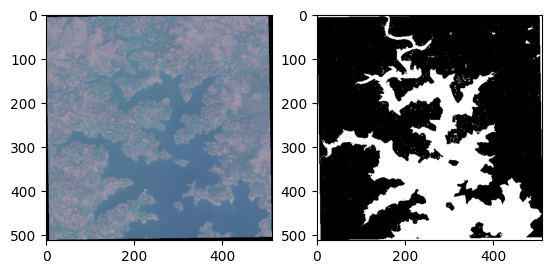

In [21]:
img, mask = train_dataset[18]

f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))


In [22]:
DEVICE='cuda'

EPOCHS=5
BATCH_SIZE=16
LR=0.001

ratio=0.5 #Various ratios could perform better for visualization
sample_num=2

ENCODER='resnet50'
WEIGHTS='imagenet'

In [24]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
)

In [25]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

c:\Users\91805\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc=smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1,loss2
        return logits

In [27]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\91805/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 33.5MB/s]


AssertionError: Torch not compiled with CUDA enabled